In [699]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegressionCV
import sklearn.metrics as metrics
from sklearn.metrics import r2_score
from sklearn.preprocessing import PolynomialFeatures
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
import sklearn.discriminant_analysis as da
import sklearn.neighbors as knn
from sklearn.model_selection import KFold
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import LassoCV
from statsmodels.api import OLS
from statsmodels.api import add_constant
import statsmodels.api as sm
import datetime

#import pydotplus
#import io
from sklearn.tree import export_graphviz
from IPython.display import Image
from IPython.display import display
%matplotlib inline
from matplotlib import pyplot
default_dims = (13, 10)
import seaborn.apionly as sns #sets up styles and gives us more plotting options
sns.set_style("whitegrid")
sns.set_context("poster")
sns.reset_orig()

In [701]:
five_factor_df = pd.read_csv('F-F_Research_Data_5_Factors_2x3_daily.CSV', index_col = 'Date')
nan_rows = five_factor_df.isnull().T.any().T
five_factor_df = five_factor_df[~nan_rows]
print(np.shape(five_factor_df))
five_factor_df.head()

(13657, 6)


,Mkt-RF,SMB,HML,RMW,CMA,RF
Date,,,,,,
19630701,-0.67,0.00,-0.32,0.01,0.15,0.012
19630702,0.79,-0.27,0.27,-0.08,-0.19,0.012
19630703,0.63,-0.17,-0.09,0.19,-0.33,0.012
19630705,0.40,0.08,-0.28,0.07,-0.33,0.012
19630708,-0.63,0.04,-0.17,-0.31,0.13,0.012


In [702]:
five_factor_df.index = pd.to_datetime(five_factor_df.index,format='%Y%m%d')

In [703]:
three_factor_df = pd.read_csv('F-F_Research_Data_Factors_daily.CSV', index_col = 'Date')
nan_rows = three_factor_df.isnull().T.any().T
three_factor_df = three_factor_df[~nan_rows]
print(np.shape(three_factor_df))
three_factor_df.head()

(24077, 4)


,Mkt-RF,SMB,HML,RF
Date,,,,
19260701,0.10,-0.24,-0.28,0.009
19260702,0.45,-0.32,-0.08,0.009
19260706,0.17,0.27,-0.35,0.009
19260707,0.09,-0.59,0.03,0.009
19260708,0.21,-0.36,0.15,0.009


In [704]:
three_factor_df.index = pd.to_datetime(three_factor_df.index,format='%Y%m%d')

In [705]:
three_factors = [x for x in three_factor_df.columns if x != 'Date' and x != 'RF']
five_factors = [x for x in five_factor_df.columns if x != 'Date' and x != 'RF']

In [706]:
# stocks_held = ['USAK', 'RHDGF', 'DXLG', 'NUSMF', 'LEE', 'AXLE']
stocks_held = ['USAK', 'RHDGF', 'DXLG', 'NUSMF', 'LEE']

In [707]:
# quantities = [180, 110, 1000, 8000, 425, 2000]
quantities = [180, 110, 1000, 8000, 425]

In [708]:
ptf_dict = {stocks_held[i]: quantities[i] for i in range(len(quantities))}

In [709]:
dfs = []
for stock in stocks_held:
    stock_df = pd.read_csv('{}.csv'.format(stock), index_col = None)
    stock_df['Stock'] = stock
    dfs.append(stock_df)

# Adds in last dataframe at the end to keep them in order
df = pd.concat(dfs)
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume,Stock
0,1992-03-19,7.5,7.5,7,7.125,7.125,1256400,USAK
1,1992-03-20,7.375,7.625,7.125,7.25,7.25,262800,USAK
2,1992-03-23,7.25,7.625,7.25,7.25,7.25,43800,USAK
3,1992-03-24,7.5,7.625,7.25,7.5,7.5,73600,USAK
4,1992-03-25,7.625,7.625,7.25,7.625,7.625,28000,USAK


In [710]:
df['Date'] = pd.to_datetime(df['Date'])

In [711]:
df = df.convert_objects(convert_numeric=True)

/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: convert_objects is deprecated.  Use the data-type specific converters pd.to_datetime, pd.to_timedelta and pd.to_numeric.
  """Entry point for launching an IPython kernel.


In [712]:
df.index = range(len(df))
df['Open'] = [df['Open'][i] * ptf_dict[df['Stock'][i]] for i in range(len(df))]
df['Close'] = [df['Close'][i] * ptf_dict[df['Stock'][i]] for i in range(len(df))]
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume,Stock
0,1992-03-19,1350.0,7.500,7.000,1282.5,7.125,1256400.0,USAK
1,1992-03-20,1327.5,7.625,7.125,1305.0,7.250,262800.0,USAK
2,1992-03-23,1305.0,7.625,7.250,1305.0,7.250,43800.0,USAK
3,1992-03-24,1350.0,7.625,7.250,1350.0,7.500,73600.0,USAK
4,1992-03-25,1372.5,7.625,7.250,1372.5,7.625,28000.0,USAK


In [893]:
df['Returns'] = np.log(df['Close']) - np.log(df['Open'])

In [1045]:
df = df[df['Date'] >= datetime.datetime(2009, 9, 11)]

In [1046]:
three_factor_df = three_factor_df[three_factor_df.index >= datetime.datetime(2009, 9, 11)]

In [1047]:
five_factor_df = five_factor_df[five_factor_df.index >= datetime.datetime(2009, 9, 11)]

In [1010]:
grouped_by_stock = df.groupby('Stock')

In [1011]:
grouped_by_date = df.groupby('Date')

In [1012]:
portfolio_values = grouped_by_date.sum()
portfolio_values.head()

,Open,High,Low,Close,Adj Close,Volume,Returns
Date,,,,,,,
2015-09-11,14732.54982,47.640001,45.629999,15133.40,45.869201,841400.0,0.146780
2015-09-14,15112.75000,48.179999,47.419999,15295.85,46.229201,361400.0,0.022918
2015-09-15,15304.05000,48.770000,47.560001,15259.30,46.839201,457900.0,0.032485
2015-09-16,15248.25000,50.310000,48.379999,15193.90,47.500333,785173.0,0.049843
2015-09-17,15255.09982,50.379999,48.910000,15360.35,48.417029,451989.0,-0.017833


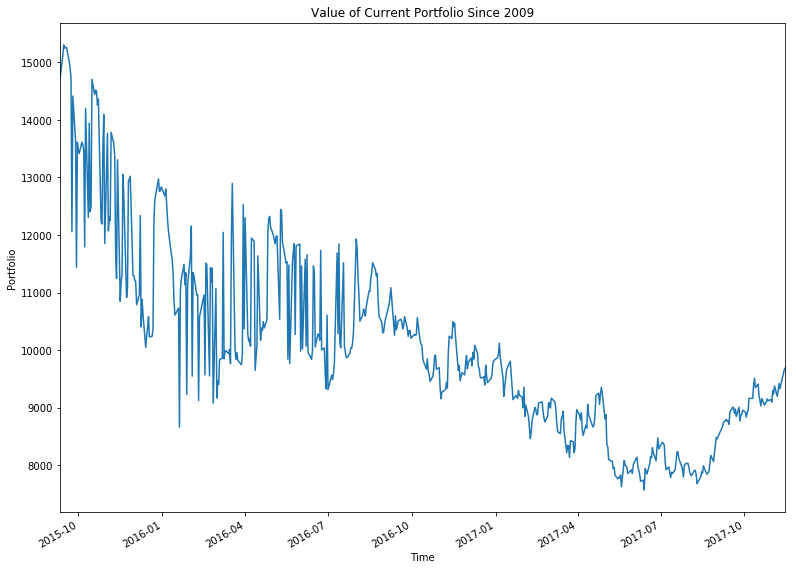

In [1013]:
fig, ax = plt.subplots(figsize=default_dims)
portfolio_values['Open'].plot();
ax.set_xlabel('Time');
ax.set_ylabel('Portfolio');
ax.set_title('Value of Current Portfolio Since 2009');

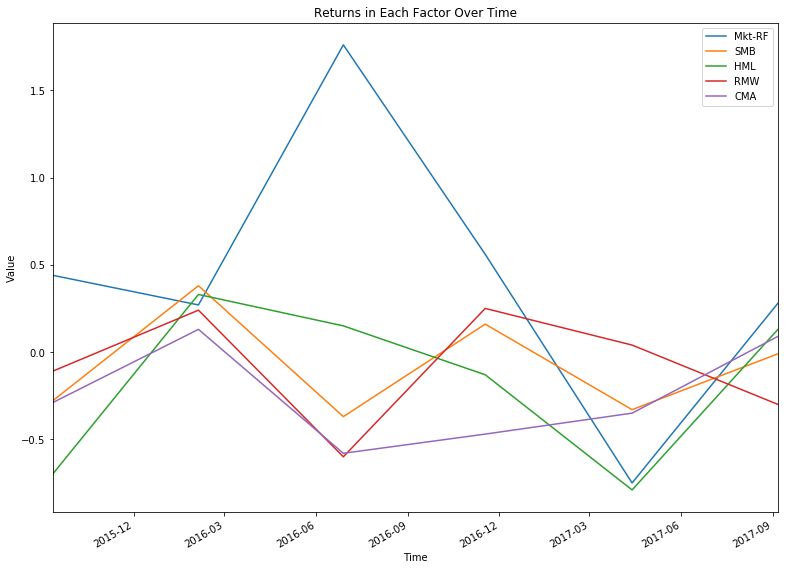

In [1014]:
msk = [True if i % 100 ==0 else False for i in range(len(three_factor_df))]
fig, ax = plt.subplots(figsize=default_dims)
for factor in five_factors:
    five_factor_df[factor][msk].plot(legend = True);
ax.set_xlabel('Time');
ax.set_ylabel('Value');
ax.set_title('Returns in Each Factor Over Time');

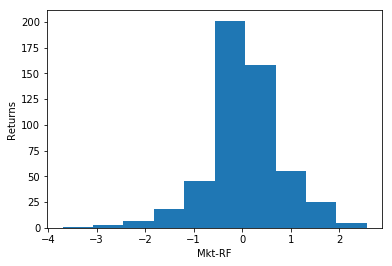

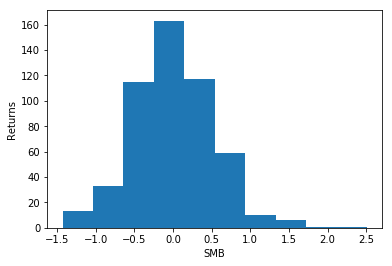

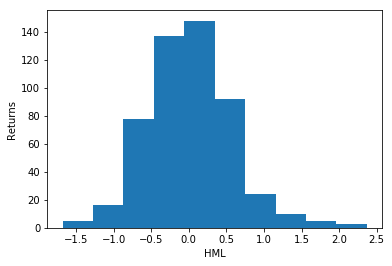

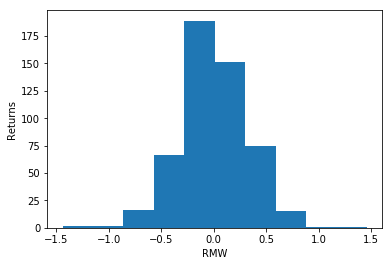

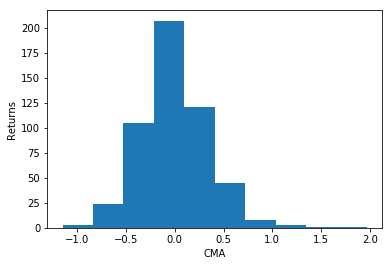

In [1015]:
for factor in five_factors:
    fig, ax = pyplot.subplots()
    plt.hist(five_factor_df[factor])
    ax.set_xlabel(factor);
    ax.set_ylabel('Returns');

In [1016]:
three_factors

['Mkt-RF', 'SMB', 'HML']

**In-sample evaluation**

In [1017]:
df_three = pd.concat([portfolio_values, three_factor_df], axis=1, join='inner')

In [1018]:
df_five = pd.concat([portfolio_values, five_factor_df], axis=1, join='inner')

In [1019]:
x_three = sm.add_constant(df_three[three_factors])

In [1020]:
x_five = sm.add_constant(df_five[five_factors])

In [1021]:
y = df_three['Returns']

In [1022]:
three_factor_OLS = sm.OLS(y, x_three.values)
three_factor_results = three_factor_OLS.fit()
three_factor_results.summary(xname = ['const'] + three_factors)

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                Returns   R-squared:                       0.101
Model:                            OLS   Adj. R-squared:                  0.096
Method:                 Least Squares   F-statistic:                     19.28
Date:                Thu, 16 Nov 2017   Prob (F-statistic):           7.33e-12
Time:                        15:08:07   Log-Likelihood:                 527.81
No. Observations:                 518   AIC:                            -1048.
Df Residuals:                     514   BIC:                            -1031.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0058      0.004     -1.508      0.132      -0.013       0.002
Mkt-RF         0.0278      0.005      5.207      0.000       0.017       0.038
SMB            0.0280      0.008      3.540      0.000       0.012       0.044
HML            0.0029      0.007      0.428      0.669      -0.011       0.016
==============================================================================
Omnibus:                        2.294   Durbin-Watson:                   2.107
Prob(Omnibus):                  0.318   Jarque-Bera (JB):                2.159
Skew:                          -0.156   Prob(JB):                        0.340
Kurtosis:                       3.053   Cond. No.                         2.16
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [1023]:
five_factor_OLS = sm.OLS(y, x_five.values)
five_factor_results = five_factor_OLS.fit()
five_factor_results.summary(xname = ['const'] + five_factors)

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                Returns   R-squared:                       0.122
Model:                            OLS   Adj. R-squared:                  0.113
Method:                 Least Squares   F-statistic:                     14.16
Date:                Thu, 16 Nov 2017   Prob (F-statistic):           5.40e-13
Time:                        15:08:07   Log-Likelihood:                 533.74
No. Observations:                 518   AIC:                            -1055.
Df Residuals:                     512   BIC:                            -1030.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0060      0.004     -1.568      0.118      -0.014       0.002
Mkt-RF         0.0330      0.006      5.899      0.000       0.022       0.044
SMB            0.0281      0.008      3.531      0.000       0.012       0.044
HML           -0.0172      0.009     -1.948      0.052      -0.035       0.000
RMW            0.0124      0.012      1.032      0.302      -0.011       0.036
CMA            0.0437      0.014      3.111      0.002       0.016       0.071
==============================================================================
Omnibus:                        1.614   Durbin-Watson:                   2.120
Prob(Omnibus):                  0.446   Jarque-Bera (JB):                1.461
Skew:                          -0.125   Prob(JB):                        0.482
Kurtosis:                       3.073   Cond. No.                         4.10
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [1024]:
capm_df = pd.read_csv('SPY.csv',index_col = 'Date')

In [1025]:
capm_df.index = pd.to_datetime(capm_df.index)

In [1026]:
df_train_capm = portfolio_values
df_train_capm['Market'] = np.log(capm_df['Close']) - np.log(capm_df['Open'])

In [1027]:
x_capm = sm.add_constant(df_train_capm['Market'])
y_capm = df_train_capm['Returns']

In [1028]:
capm_OLS = sm.OLS(y_capm, x_capm)
capm_results = capm_OLS.fit()
capm_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                Returns   R-squared:                       0.089
Model:                            OLS   Adj. R-squared:                  0.087
Method:                 Least Squares   F-statistic:                     53.36
Date:                Thu, 16 Nov 2017   Prob (F-statistic):           9.85e-13
Time:                        15:08:08   Log-Likelihood:                 567.00
No. Observations:                 551   AIC:                            -1130.
Df Residuals:                     549   BIC:                            -1121.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0052      0.004     -1.409      0.159      -0.012       0.002
Market         4.8973      0.670      7.305      0.000       3.580       6.214
==============================================================================
Omnibus:                        3.807   Durbin-Watson:                   2.091
Prob(Omnibus):                  0.149   Jarque-Bera (JB):                3.597
Skew:                          -0.184   Prob(JB):                        0.166
Kurtosis:                       3.144   Cond. No.                         182.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

**Out-of-sample evaluation**

In [1029]:
def split(x,y):
    np.random.seed(9001)
    msk = np.random.rand(len(x)) < .75
    return x[msk], x[~msk], y[msk], y[~msk]

In [1030]:
x_train_three, x_test_three, y_train, y_test = split(x_three, y)

In [1031]:
three_factor_OLS = sm.OLS(y_train, x_train_three.values)
results_sm = three_factor_OLS.fit()
print('Three factor test r2 of {}'.format(r2_score(y_test, results_sm.predict(x_test_three.values))))

Three factor test r2 of 0.009086934693001036


In [1032]:
x_train_five, x_test_five, y_train, y_test = split(x_five, y)

In [1033]:
five_factor_OLS = sm.OLS(y_train, x_train_five.values)
results_sm = five_factor_OLS.fit()
print('Five factor test r2 of {}'.format(r2_score(y_test, results_sm.predict(x_test_five.values))))

Five factor test r2 of 0.024937288581950323


In [1034]:
x_train_capm, x_test_capm, y_train_capm, y_test_capm = split(x_capm, y_capm)

In [1035]:
capm_OLS = sm.OLS(y_train_capm, x_train_capm.values)
results_sm = capm_OLS.fit()
print('CAPM test r2 of {}'.format(r2_score(y_test_capm, results_sm.predict(x_test_capm.values))))

CAPM test r2 of 0.011300113346458418


**EDA for Value Factor**

In [1036]:
value_df = pd.read_csv('RZV.csv', index_col = 'Date')

In [1037]:
value_df.index = pd.to_datetime(value_df.index)

In [1038]:
df_value = portfolio_values
df_value['Value'] = np.log(value_df['Close']) - np.log(value_df['Open'])
df_value = df_value.dropna()

In [1039]:
x_value = sm.add_constant(df_value['Value'])
y_value = df_value['Returns']

In [1040]:
value_OLS = sm.OLS(y_value, x_value)
value_results = value_OLS.fit()
value_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                Returns   R-squared:                       0.113
Model:                            OLS   Adj. R-squared:                  0.111
Method:                 Least Squares   F-statistic:                     69.61
Date:                Thu, 16 Nov 2017   Prob (F-statistic):           5.87e-16
Time:                        15:08:10   Log-Likelihood:                 574.34
No. Observations:                 551   AIC:                            -1145.
Df Residuals:                     549   BIC:                            -1136.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0032      0.004     -0.867      0.386      -0.010       0.004
Value          2.6456      0.317      8.343      0.000       2.023       3.268
==============================================================================
Omnibus:                        3.470   Durbin-Watson:                   2.112
Prob(Omnibus):                  0.176   Jarque-Bera (JB):                3.326
Skew:                          -0.144   Prob(JB):                        0.190
Kurtosis:                       3.248   Cond. No.                         87.1
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [1041]:
x_train_value, x_test_value, y_train_value, y_test_value = split(x_value, y_value)
value_OLS = sm.OLS(y_train_value.values, x_train_value.values)
results_sm = value_OLS.fit()
print('Value factor test r2 of {}'.format(r2_score(y_test_value, results_sm.predict(x_test_value.values))))

Value factor test r2 of 0.05165821897416489


In [1042]:
x_value = df_five['SMB']
y_value = df_five['Returns']

In [1043]:
x_train_value, x_test_value, y_train_value, y_test_value = split(x_value, y_value)
value_OLS = sm.OLS(y_train_value.values, x_train_value.values)
results_sm = value_OLS.fit()
print('Value factor test r2 of {}'.format(r2_score(y_test_value, results_sm.predict(x_test_value.values))))

Value factor test r2 of 0.025474552215831614


In [1044]:
for stock in stocks_held:
    stock_group = grouped_by_stock.get_group(stock).groupby('Date').sum()
    temp_df = pd.concat([stock_group, five_factor_df], axis=1, join='inner').dropna()
    x = sm.add_constant(temp_df[five_factors])
    y = temp_df['Returns']
    x_train, x_test, y_train, y_test = split(x, y)
    OLS = sm.OLS(y_train, x_train)
    results = OLS.fit()
    print(results.summary(title=stock))

                                     USAK                                     
Dep. Variable:                Returns   R-squared:                       0.163
Model:                            OLS   Adj. R-squared:                  0.152
Method:                 Least Squares   F-statistic:                     14.52
Date:                Thu, 16 Nov 2017   Prob (F-statistic):           5.22e-13
Time:                        15:08:12   Log-Likelihood:                 738.50
No. Observations:                 378   AIC:                            -1465.
Df Residuals:                     372   BIC:                            -1441.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0001      0.002     -0.079      0.9